#Same Pre-processing steps followed in the proposed Deep learning models

**Dataset Link:**

https://drive.google.com/drive/folders/1NHikQIu29Ht2HpYeMzoV0Dfwrl__yM01?usp=sharing 

In [ ]:
import numpy as np 
import pandas as pd 
import os

import matplotlib.pyplot as plt
import csv
import itertools
import collections

import pywt
from scipy import stats

from sklearn.utils import resample
from sklearn.model_selection import train_test_split

import keras
from keras.models import Sequential
from keras.layers import Conv1D, AvgPool1D, Flatten, Dense, Dropout, Softmax,LSTM,GRU
from tensorflow.keras.optimizers import Adam 
from keras.utils.np_utils import to_categorical
from keras.utils.vis_utils import plot_model
from keras import regularizers


%matplotlib inline

#Matplotlib setup
plt.rcParams["figure.figsize"] = (3,1)
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.color'] = 'b'
plt.rcParams['axes.grid'] = True 

In [ ]:
path = '/content/drive/MyDrive/Dataset/mitbih_database/mitbih_database/'
window_size = 180
maximum_counting = 10000

classes = ['N', 'L', 'R', 'A', 'V']
n_classes = len(classes)
count_classes = [0]*n_classes

X = list()
y = list()

In [ ]:

filenames = next(os.walk(path))[2]


records = list()
annotations = list()
filenames.sort()

In [ ]:

for f in filenames:
    filename, file_extension = os.path.splitext(f)
    
    # *.csv
    if(file_extension == '.csv'):
        records.append(path + filename + file_extension)

    # *.txt
    else:
        annotations.append(path + filename + file_extension)

In [ ]:
def denoise(data): 
    w = pywt.Wavelet('sym4')
    maxlev = pywt.dwt_max_level(len(data), w.dec_len) 
    threshold = 0.04

    coeffs = pywt.wavedec(data, 'sym4', level=maxlev)
    for i in range(1, len(coeffs)):
        coeffs[i] = pywt.threshold(coeffs[i], threshold*max(coeffs[i]))
        
    datarec = pywt.waverec(coeffs, 'sym4')
    
    return datarec

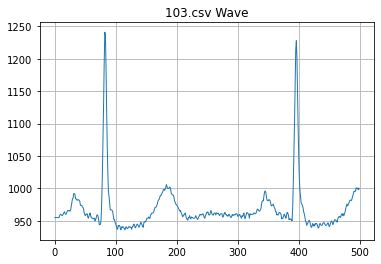

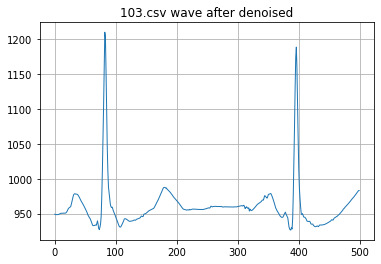

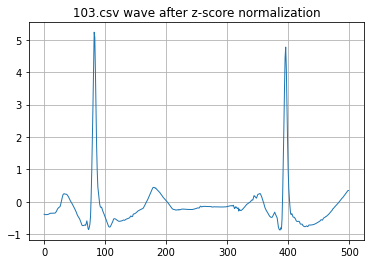

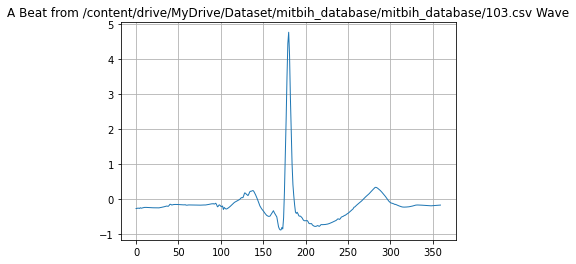

(100012, 360) (100012,)


In [ ]:

for r in range(0,len(records)):
    signals = []

    with open(records[r], 'rt') as csvfile:
        spamreader = csv.reader(csvfile, delimiter=',', quotechar='|') # read CSV file\
        row_index = -1
        for row in spamreader:
            if(row_index >= 0):
                signals.insert(row_index, int(row[1]))
            row_index += 1
            
   
    if r is 1:
        
        plt.title("103.csv Wave")
        plt.plot(signals[0:500])
        
        plt.show()
        
    signals = denoise(signals)
   
    if r is 1:
        
        plt.title("103.csv wave after denoised")
        plt.plot(signals[0:500])
        plt.show()
        
    signals = stats.zscore(signals)
    
    if r is 1:
       
        plt.title( " 103.csv wave after z-score normalization ")
        plt.plot(signals[0:500])
        plt.show()
    
   
    example_beat_printed = False
    with open(annotations[r], 'r') as fileID:
        data = fileID.readlines() 
        beat = list()

        for d in range(1, len(data)): 
            splitted = data[d].split(' ')
            splitted = filter(None, splitted)
            next(splitted) 
            pos = int(next(splitted)) 
            arrhythmia_type = next(splitted) 
            if(arrhythmia_type in classes):
                arrhythmia_index = classes.index(arrhythmia_type)
                count_classes[arrhythmia_index] += 1
                if(window_size <= pos and pos < (len(signals) - window_size)):
                    beat = signals[pos-window_size:pos+window_size]    
                    if r is 1 and not example_beat_printed: 
                        plt.title("A Beat from " + records[3] + " Wave")
                        plt.plot(beat)
                        plt.show()
                        example_beat_printed = True

                    X.append(beat)
                    y.append(arrhythmia_index)


print(np.shape(X), np.shape(y))


In [ ]:
for i in range(0,len(X)):
        X[i] = np.append(X[i], y[i])


print(np.shape(X))

(100012, 361)


0.0    75011
1.0     8071
2.0     7255
4.0     7129
3.0     2546
Name: 360, dtype: int64


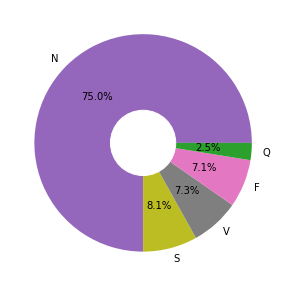

In [ ]:
df = pd.DataFrame(X) 
per_class = df[df.shape[1]-1].value_counts()
print(per_class)
plt.figure(figsize=(5,5))
my_circle=plt.Circle( (0,0), 0.3, color='white')
plt.pie(per_class, labels=['N', 'S', 'V', 'F', 'Q'], colors=['tab:purple','tab:olive','tab:grey','tab:pink','tab:green'],autopct='%1.1f%%')
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.show()

###Train Test split

In [ ]:
train,test=train_test_split(df,test_size=0.20)
print("train : ", np.shape(train))
print("test  : ", np.shape(test))

train :  (80009, 361)
test  :  (20003, 361)


###Sampling in train data

In [ ]:
#down sampling class 0
df_0=(train[train[train.shape[1]-1]==0]).sample(7000,random_state=42)

#up sampling class 1
df_1=train[train[train.shape[1]-1]==1]
df_1_upsample=resample(df_1,replace=True,n_samples=7000,random_state=23)

#up sampling class 2
df_2=train[train[train.shape[1]-1]==2]
df_2_upsample=resample(df_2,replace=True,n_samples=7000,random_state=23)

#up sampling class 3
df_3=train[train[train.shape[1]-1]==3]
df_3_upsample=resample(df_3,replace=True,n_samples=7000,random_state=23)

#up sampling class 4
df_4=train[train[train.shape[1]-1]==4]
df_4_upsample=resample(df_4,replace=True,n_samples=7000,random_state=23)


In [ ]:
train_df=pd.concat([df_0,df_1_upsample,df_2_upsample,df_3_upsample,df_4_upsample])

3.0    7000
4.0    7000
2.0    7000
1.0    7000
0.0    7000
Name: 360, dtype: int64


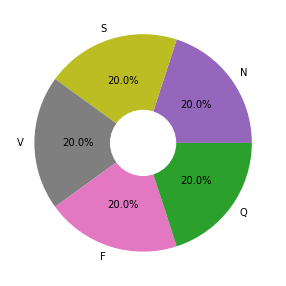

In [ ]:
per_class = train_df[train_df.shape[1]-1].value_counts()
print(per_class)
plt.figure(figsize=(5,5))
my_circle=plt.Circle( (0,0), 0.3, color='white')
plt.pie(per_class, labels=['N', 'S', 'V', 'F', 'Q'], colors=['tab:purple','tab:olive','tab:grey','tab:pink','tab:green'],autopct='%1.1f%%')
p=plt.gcf()
p.gca().add_artist(my_circle)
#plt.title("Sampling in train data")
plt.show()

###X,y in test data

In [ ]:
#test data 
test_x= test.iloc[:,:test.shape[1]-1].values
#test_x=test_x.reshape(len(test_x), test_x.shape[1],1)
test_y= test[test.shape[1]-1]
test_y=to_categorical(test_y)

In [ ]:
print("test_x : ", np.shape(test_x))
print("test_y  : ", np.shape(test_y))

test_x :  (20003, 360)
test_y  :  (20003, 5)


0.0    14993
1.0     1617
4.0     1435
2.0     1427
3.0      531
Name: 360, dtype: int64


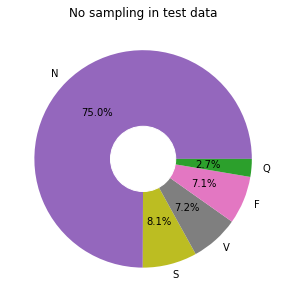

In [ ]:
per_class = test[test.shape[1]-1].value_counts()
print(per_class)
plt.figure(figsize=(5,5))
my_circle=plt.Circle( (0,0), 0.3, color='white')
plt.pie(per_class, labels=['N', 'S', 'V', 'F', 'Q'], colors=['tab:purple','tab:olive','tab:grey','tab:pink','tab:green'],autopct='%1.1f%%')
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.title("No sampling in test data")
plt.show()

###train,val from train data 

In [ ]:
##just for this 1 fold splitting of test and train
Train, val = train_test_split(train_df, test_size=0.20)

print("X_train : ", np.shape(Train))
print("X_test  : ", np.shape(val))

X_train :  (28000, 361)
X_test  :  (7000, 361)


In [ ]:
train_df.shape #sampled train data

(35000, 361)

In [ ]:
test.shape

(20003, 361)

In [ ]:
Train=train_df

In [ ]:
Train.shape

(35000, 361)

###X,y for KNN

In [ ]:
target_train=Train[Train.shape[1]-1] #label train
#target_val=val[val.shape[1]-1] #labes test
Train_y=to_categorical(target_train)
#val_y=to_categorical(target_val)
print(np.shape(Train_y))

Train_x = Train.iloc[:,:Train.shape[1]-1].values
#val_x = val.iloc[:,:val.shape[1]-1].values
#Train_x = Train_x.reshape(len(Train_x), Train_x.shape[1],1)
#val_x = val_x.reshape(len(val_x),val_x.shape[1],1)
print(np.shape(Train_x))

(35000, 5)
(35000, 360)


Model fitting

In [ ]:
#Random forest classifier
from sklearn.neighbors import KNeighborsClassifier
rfc=KNeighborsClassifier()
rfc.fit(Train_x,Train_y)

KNeighborsClassifier()

###Evaluation

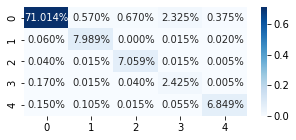

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
y_true=[]
for element in test_y:
    y_true.append(np.argmax(element))
prediction_proba=rfc.predict(test_x)
prediction=np.argmax(prediction_proba,axis=1)
model_cf_matrix = confusion_matrix(y_true, prediction)
plt.figure(figsize=(5,2))
sns.heatmap(model_cf_matrix/np.sum(model_cf_matrix), annot=True,fmt='.3%', cmap='Blues')

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
result = confusion_matrix(y_true, prediction)
print("Confusion Matrix:")
print(result)
result1 = classification_report(y_true, prediction)
print("Classification Report:",)
print (result1)
result2 = accuracy_score(y_true,prediction)
print("Accuracy:",result2)

Confusion Matrix:
[[14205   114   134   465    75]
 [   12  1598     0     3     4]
 [    8     3  1412     3     1]
 [   34     3     8   485     1]
 [   30    21     3    11  1370]]
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.95      0.97     14993
           1       0.92      0.99      0.95      1617
           2       0.91      0.99      0.95      1427
           3       0.50      0.91      0.65       531
           4       0.94      0.95      0.95      1435

    accuracy                           0.95     20003
   macro avg       0.85      0.96      0.89     20003
weighted avg       0.97      0.95      0.96     20003

Accuracy: 0.9533569964505324
